# TRABAJO 1: ENSEMBLE LEARNING | MACHINE LEARNING II
## Feb 2023
--- 

### GRUPO: xxxx
- Nombre y Apellidos
- Nombre y Apellidos
- ...
- Nombre y Apellidos

--- 

**IMPORTANTE:**
- Asegúrate, fijando la semilla de los nº aleatorios según proceda, que si se vuelve a ejecutar el cuaderno los resultados son idénticos
- Responde a las preguntas planteadas utilizando instrucciones "print" que permitan leer cómodamente como resultado de la ejecución de la celda el texto explicativo junto a las figuras o tablas a las que haga referencia (mira el ejemplo en la primera gráfica que se representa). También puedes usar markdown para responder.
- No escribas líneas de código muy largas, tienes una regla para ayudarte a no hacerlo
- No cambies la estructura del documento, respeta las secciones que ya existen


---
Importamos todos los paquetes aquí por comodidad

In [2]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from mltools import model_tools as MT
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from mltools import classification_tools as CT
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

# For reproducibility
import pickle

#imblearn

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


import warnings
warnings.filterwarnings("ignore")

### 1. AJUSTE DE LOS MODELOS CON EL DATASET AJU_DATOS_DEM_C3

Se trata de estimar la variable FESTIVO (1: el día es festivo) a partir de las variables disponibles en el dataset que se consideren oportunas. NO se pueden utilizar como variables de entrada: FECHA, DIA ni ANNO. La FECHA es interesante manejarla simplemente como ayuda para entender lo que esté pasando.

Se deben ajustar diferentes modelos, buscando un buen compromiso entre la complejidad y el error en cada uno de ellos. El objetivo es conseguir un buen modelo con una gran capacidad de acierto en el futuro. Modelos que deben crearse, analizando los resultados de cada uno de ellos (errores e importancias de las variables):
- Simple tree
- Bagged  tree
- Random Forest
- Gradient boosting
- Stacking

Carga de datos

In [3]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

def read_data():
    df_aju = pd.read_csv('AJU_DATOS_DEM_C3.csv')

    # parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
    # esta variable NO se puede utilizar como entrada en los modelos
    df_aju.FECHA = pd.to_datetime(df_aju.FECHA, format='%d/%m/%Y') 
    s=df_aju.loc[:,'FECHA']
    df_aju['FECHA'] =  s.dt.date

    # eliminamos las variables que no se pueden usar como entradas en los modelos
    del df_aju['ANNO']
    del df_aju['DIA']
    return df_aju

df_aju = read_data()

print('Tamaño de df_orig con los datos cargados:', df_aju.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_aju

Tamaño de df_orig con los datos cargados: (2879, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):


,FECHA,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,...,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,FESTIVO,TMIN,TMAX
0,2014-01-01,0.040942,0.038985,0.036382,0.034416,0.033409,0.033420,0.034054,0.034229,0.035889,...,0.055197,0.054185,0.051063,0.046240,0.041000,1,3,1,12.3,20.2
1,2014-01-02,0.033950,0.030996,0.029517,0.028966,0.029165,0.030150,0.032944,0.036510,0.041196,...,0.055820,0.054451,0.051482,0.046145,0.040880,1,4,0,12.0,20.1
2,2014-01-03,0.035463,0.032112,0.030292,0.029521,0.029450,0.030515,0.033188,0.036656,0.041052,...,0.055230,0.053520,0.050286,0.045412,0.040025,1,5,0,13.2,21.0
3,2014-01-04,0.035959,0.032772,0.031034,0.030178,0.030135,0.030782,0.032598,0.034982,0.039299,...,0.053757,0.052620,0.049973,0.044970,0.040386,1,6,0,14.4,23.4
4,2014-01-05,0.037506,0.034148,0.031878,0.031126,0.030930,0.031604,0.033066,0.034803,0.038758,...,0.052902,0.051481,0.049655,0.045730,0.040905,1,7,0,12.8,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,2021-12-27,0.033180,0.031299,0.030173,0.029493,0.029649,0.030814,0.033925,0.037837,0.042098,...,0.051685,0.050563,0.047267,0.042237,0.037797,12,1,0,16.1,23.0
2875,2021-12-28,0.033823,0.031731,0.030385,0.029950,0.030017,0.031203,0.034708,0.038432,0.042645,...,0.051867,0.050971,0.047718,0.042585,0.037774,12,2,0,16.6,22.7
2876,2021-12-29,0.034475,0.032198,0.030902,0.030441,0.030384,0.031487,0.034454,0.038381,0.042850,...,0.052136,0.050604,0.046788,0.042033,0.037595,12,3,0,14.3,21.3
2877,2021-12-30,0.034345,0.031919,0.030524,0.029991,0.030087,0.031286,0.034384,0.038574,0.042778,...,0.052092,0.050993,0.047587,0.042807,0.038252,12,4,0,13.4,26.4


Visión general de las series

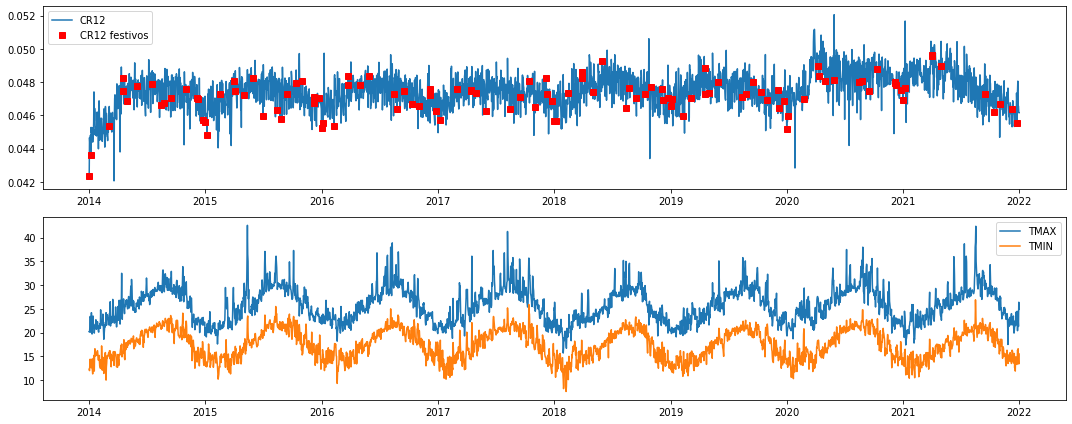

Se observa que el nº de festivos (115) es claramente inferior al nº de laborables (2764)
En concreto, el porcentaje de festivos en el conjunto de ajuste es 3.99444251476207 %


In [14]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
fig = plt.figure(1, figsize=(15,6))
ax1 = plt.subplot(2,1,1)

ind_festivo = df_aju.FESTIVO == 1

plt.plot(df_aju.FECHA, df_aju.CR12, label='CR12')

plt.plot(df_aju.FECHA[ind_festivo], df_aju.CR12[ind_festivo], 'sr', label='CR12 festivos')
plt.legend()

plt.subplot(2,1,2,sharex= ax1)
plt.plot(df_aju.FECHA, df_aju.TMAX, label='TMAX')
plt.plot(df_aju.FECHA, df_aju.TMIN, label='TMIN')
plt.tight_layout()
plt.legend()

plt.show()

num_festivos = np.count_nonzero(df_aju.FESTIVO)
num_laborables = df_aju.shape[0] - num_festivos
print(f'Se observa que el nº de festivos ({num_festivos}) es claramente inferior al nº de laborables ({num_laborables})')
print(f'En concreto, el porcentaje de festivos en el conjunto de ajuste es {100*num_festivos /  df_aju.shape[0]} %')
# fig.savefig('figura1.pdf')

---
### 1.1 Análisis exploratorio básico del problema

- Incluye un análisis que te permita comprender la naturaleza del problema, cómo son las variables de entrada, su interrelación, así como su relación con la variable de salida
- Comenta todo lo que parezca relevante para el tema tratado, incluyendo todas las gráficas que consideres oportunas
- Estudia cómo se reparten los festivos según el día de la semana y los meses

In [5]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### Prepara los conjuntos de entrenamiento y test

- Divide los datos disponibles de ajuste (df_aju) en dos conjuntos diferentes (TR:80% y TS: 20%). TS lo deberías de utilizar para validar la calidad de los diferentes modelos que se creen.
- Recuerda fijar una semilla para garantizar que la separación es reproducible

In [15]:
df_aju['FESTIVO'] = df_aju['FESTIVO'].astype('category')

In [4]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos

def split_dataset():
    
    # Define input and output matrices
    INPUTS = df_aju.columns[~df_aju.columns.isin(['FESTIVO', 'FECHA'])]
    OUTPUT = 'FESTIVO'
    X = df_aju[INPUTS]
    y = df_aju[OUTPUT]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,  #percentage of test data
                                                        random_state=0, #seed for replication
                                                        stratify = y)   #Preserves distribution of y
    return INPUTS, OUTPUT, X_train, X_test, y_train, y_test

INPUTS, OUTPUT, X_train, X_test, y_train, y_test = split_dataset()
# # Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos
# df_aju_tr = X_train.copy()
# df_aju_tr['FESTIVO'] = y_train # We will call Y as output variable for simplicity
# df_aju_ts = X_test.copy()
# df_aju_ts['FESTIVO'] = y_test # We will call Y as output variable for simplicity>

#### 1.2. Ajusta un modelo de clasificación sencillo que sea robusto y que pueda servir de referencia de comparación con otros modelos más complejos.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables

In [17]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_DT = INPUTS

# Cuanto mas grande sea el min_impurity_decrease, mas sencillo va a ser mi árbol (es un hyperparameter)
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure - también se puede utilizar "entropy"
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045])},
             scoring='accuracy')

In [18]:
# Show the best grid parameter combination found by CV
tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 150,
 'splitter': 'best'}

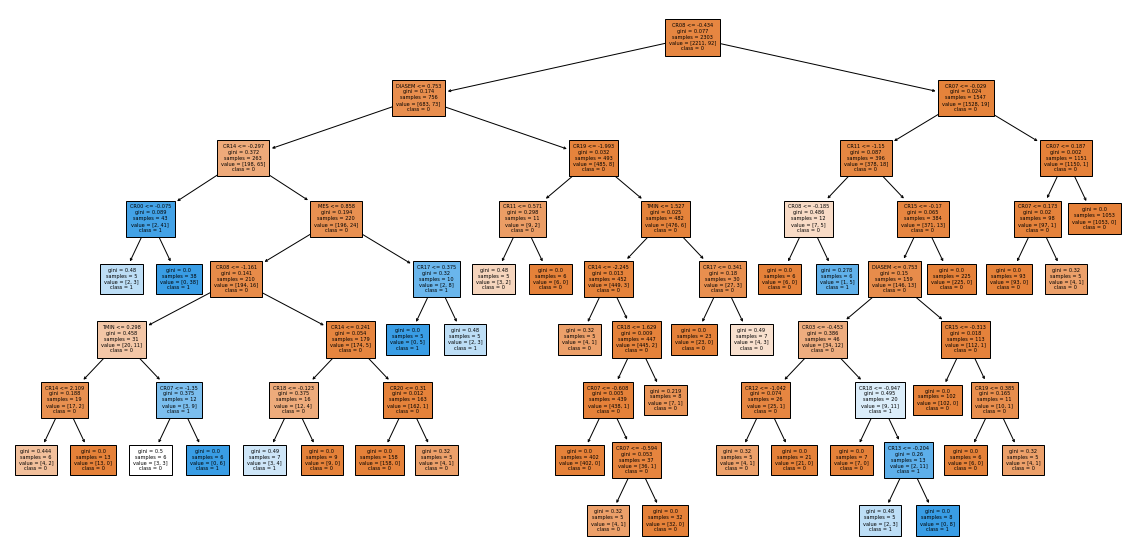

In [19]:
## Plot the decision tree model (use figsize and fontsize for getting the best view)
plt.figure(figsize=(20, 10))
plot_tree(tree_fit.best_estimator_['DT'], # Utiliza los parámetros óptimos obtenidos de la búsqueda de la cuadrícula
          feature_names= INPUTS_DT, # Lista de variables utilizadas en el modelo
          class_names= [str(s) for s in y_train.unique()], # Lista de nombres de las clases objetivo en el modelo
          fontsize=5, # Tamaño de fuente utilizado en la visualización del árbol
          filled=True) # Las cajas del árbol se colorearán según la mayoría de la clase objetivo
plt.show()

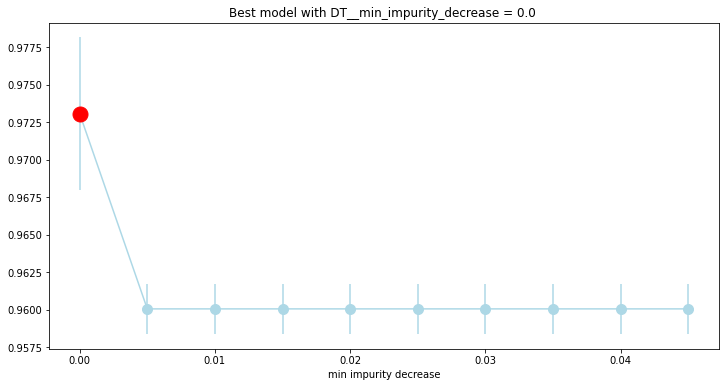

In [20]:
MT.plotModelGridError(tree_fit)

In [21]:
clf = tree_fit.best_estimator_['DT']
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
# Se calcula la precisión y la precisión equilibrada
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

# Se crean las confusion matrixs
print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1, 0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1, 0])

                         TR        TS
Accuracy           0.960052  0.960069
Balanced accuracy  0.500000  0.500000

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1  0   92
         0  0 2211

Accuracy: 0.96
No Information Rate: 0.96
P-Value [Acc > NIR]: 0.53
Kappa: 0.0
Mcnemar's Test P-Value: 0.0
Sensitivity: 1.0
Specificity: 0.0
Precision: 0.0
Recall: 0.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 1.0
Balanced accuracy: 0.5
F1 Score: 0.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1  0  23
         0  0 553

Accuracy: 0.96
No Information Rate: 0.96
P-Value [Acc > NIR]: 0.56
Kappa: 0.0
Mcnemar's Test P-Value: 0.0
Sensitivity: 1.0
Specificity: 0.0
Precision: 0.0
Recall: 0.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 1.0
Balanced accuracy: 0.5
F1 Score: 0.0
Positive label: 1


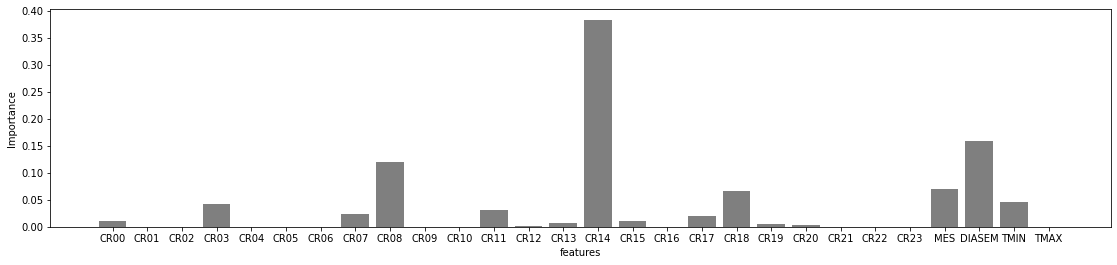

In [22]:
## Plot the variable importance of each feature
plt.figure(figsize=(19, 4))
bar_width = 0.35
plt.bar(INPUTS_DT, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.show()

In [23]:
smote = SMOTE(random_state = 11)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# Define pipeline with SMOTE to balance classes
pipe_balanced = imbalanced_make_pipeline(DecisionTreeClassifier(criterion='gini',
                                                                 class_weight='balanced',
                                                                 min_samples_split=5, 
                                                                 min_samples_leaf=5, 
                                                                 random_state=150))

# Fit the balanced pipeline
pipe_balanced.fit(X_train_SMOTE[INPUTS_DT], y_train_SMOTE)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        min_samples_leaf=5, min_samples_split=5,
                                        random_state=150))])

In [24]:
# Make predictions on the training and test sets
y_train_pred2 = pipe_balanced.predict(X_train_SMOTE[INPUTS_DT]).tolist()
y_test_pred2 = pipe_balanced.predict(X_test[INPUTS_DT]).tolist()

# Calculate the accuracy and balanced accuracy scores
acc_tr2 = metrics.accuracy_score(y_train_SMOTE, y_train_pred2)
acc_ts2 = metrics.accuracy_score(y_test, y_test_pred2)
acc_bal_tr2 = metrics.balanced_accuracy_score(y_train_SMOTE, y_train_pred2)
acc_bal_ts2 = metrics.balanced_accuracy_score(y_test, y_test_pred2)

# Print the accuracy and balanced accuracy scores
dfacc = pd.DataFrame(
    [[acc_tr2, acc_ts2], [acc_bal_tr2, acc_bal_ts2]],
    index=['Accuracy', 'Balanced accuracy'],
    columns=['TR', 'TS'])
print(dfacc)

# Se crean las confusion matrixs
print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train_SMOTE, y_train_pred2, labels=[1, 0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred2, labels=[1, 0]) 

                         TR        TS
Accuracy           0.992311  0.961806
Balanced accuracy  0.992311  0.813429

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    1    0
         1 2194   17
         0   17 2194

Accuracy: 0.99
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.98
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.99
Specificity: 0.99
Precision: 0.99
Recall: 0.99
Prevalence: 0.5
Detection Rate: 0.5
Detection prevalence: 0.5
Balanced accuracy: 0.99
F1 Score: 0.99
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 15   8
         0 14 539

Accuracy: 0.96
No Information Rate: 0.91
P-Value [Acc > NIR]: 0.47
Kappa: 0.56
Mcnemar's Test P-Value: 0.29
Sensitivity: 0.97
Specificity: 0.65
Precision: 0.52
Recall: 0.65
Prevalence: 0.96
Detection Rate: 0.94
Detection prevalence: 0.95
Balanced accuracy: 0.81
F1 Score: 0.58
Positive label: 1


#### 1.3. Ajusta un bagged tree para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

**1.3.1 Fit optimal classification bagged tree using Grid Search**

El siguiente código busca el nº óptimo de árboles de decisión a usar en un modelo de ensamble utilizando la técnica de Bagging.

El GridSearchCV realiza una búsqueda exhaustiva de los parámetros en el rango especificado y devuelve el mejor valor para el parámetro n_estimators, que maximiza la precisión del modelo.

In [7]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeClassifier( criterion='gini',  # impurity measure
                                                            min_samples_split=2, # Número mínimo de observaciones en un nodo para seguir dividiendolo
                                                            min_samples_leaf=1, # Número mínimo de observaciones en un nodo hoja (terminal)
                                                            random_state=999))]) # For replication
# find optim nº of trees in the ensemble
param = {'BT__n_estimators': range(20, 150, 5)} # Rango del nº de árboles a usar en el ensamble

pipe =  Pipeline(steps=[('BT', 
                            BaggingClassifier(base_estimator=base_estimator,
                                              random_state=150))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
# Busca el valor óptimo de n_estimators, utilizando la validación cruzada con 10 folds
nFolds = 10
bt_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_BT = INPUTS  
bt_fit.fit(X_train[INPUTS_BT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('BT',
                                        BaggingClassifier(base_estimator=Pipeline(steps=[('DT',
                                                                                          DecisionTreeClassifier(random_state=999))]),
                                                          random_state=150))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 150, 5)},
             scoring='accuracy')

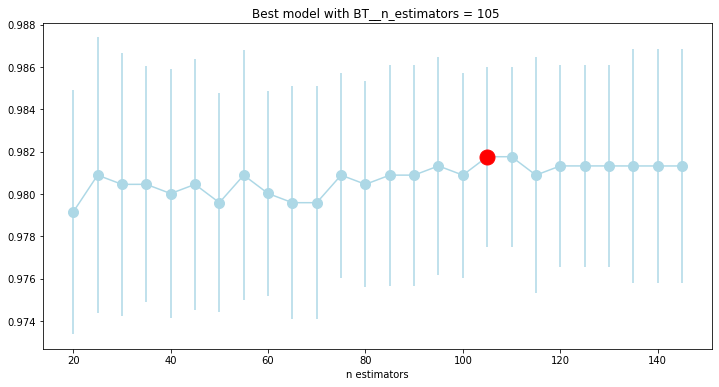

In [8]:
MT.plotModelGridError(bt_fit)

**1.3.2. Reentrenamos el modelo insertando manualmente el número de árboles óptimos**
Una vez sabiendo el número de árboles óptimos a introducir en el modelo lo voy a volver a entrenar insertando de forma manual el número de árboles que en este caso es 105 para obtener las métricas deseadas.

In [9]:
number_estimators = 105 # El número de árboles que vamos a entrenar
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeClassifier( criterion='gini',  # impurity measure
                                                            min_samples_split=2, # Número mínimo de observaciones en un nodo para seguir dividiendolo
                                                            min_samples_leaf=1, # Número mínimo de observaciones en un nodo hoja (terminal)
                                                            random_state=999))]) # For replication


bag_class_estim = BaggingClassifier(base_estimator=base_estimator,
                                    n_estimators=number_estimators,
                                    random_state=0)
                     
# fit the bagged trees
INPUTS_BT = INPUTS  
INPUTS_DT = INPUTS
bag_class_estim.fit(X_train[INPUTS_BT], y_train)

BaggingClassifier(base_estimator=Pipeline(steps=[('DT',
                                                  DecisionTreeClassifier(random_state=999))]),
                  n_estimators=105, random_state=0)

In [14]:
# model predictions in training (TR) and test (TS) sets
# Se realiza una predicción con el modelo de Bagging ya entrenado sobre el 
# conjunto de train y test.
clf = bag_class_estim
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1, 0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1, 0])

# Accuracy -> medida de rendimiento que indica la proporción de predicciones
# correctas realizadas por el modelo en relación al total de predicciones 
# realizadas. 
#  nº predicciones correctas / nº total de predicciones

# Balanced accuracy -> medida de rendimiento que tiene en cuenta el desequilibrio
# de las clases en los datos de train. La precisión equilibrada es la media de
# la sensibilidad y la especifidad del modelo. Esta medida es más adecuada
# cuando las clases están desequilibradas en los datos de train.

                    TR        TS
Accuracy           1.0  0.986111
Balanced accuracy  1.0  0.867757

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 92    0
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 17   6
         0  2 551

Accuracy: 0.99
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.8
Mcnemar's Test P-Value: 0.29
Sensitivity: 1.0
Specificity: 0.74
Precision: 0.89
Recall: 0.74
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.97
Balanced accuracy: 0.87
F1 Score: 0.81
Positive label: 1


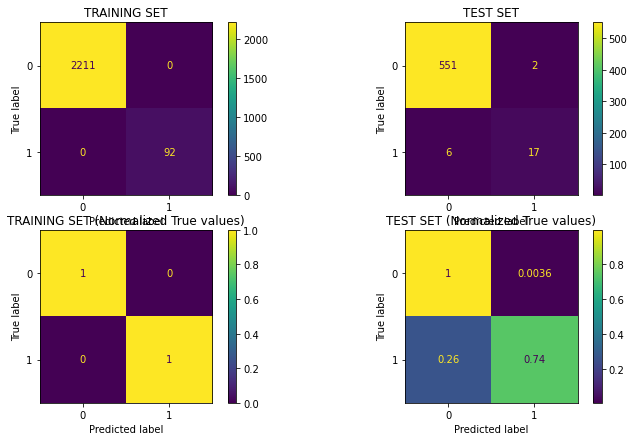

In [15]:
fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

**1.3.3. Feature importance evaluation in bagging using "Permutation importance"**
La importancia de permutación de una característica se calcula de la siguiente manera:

- Primero, se evalúa una métrica de referencia, definida por el puntaje, en un conjunto de datos (potencialmente diferente) definido por X.
- Luego, se permuta una columna de características del conjunto de validación y se vuelve a evaluar la métrica.
- La importancia de la permutación se define como la diferencia entre la métrica de referencia y la métrica obtenida al permutar la columna de características.

Para más información, consulte L. Breiman, "Random Forests", Machine Learning, 45(1), 5-32, 2001.

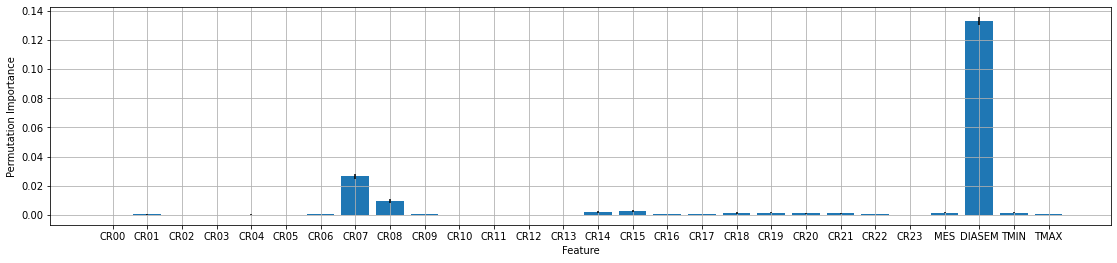

In [16]:
importances_bag_class_estim = permutation_importance(bag_class_estim, 
                                    X_train[INPUTS_DT], y_train,
                                    n_repeats=10, # Repite 10 veces la alteriacion de las variables y coge la media de estos resultados, es una especie de validación cruzada
                                    random_state=0)

fig = plt.figure(2, figsize=(19, 4)) 
plt.bar(INPUTS_DT, importances_bag_class_estim.importances_mean, yerr=importances_bag_class_estim.importances_std)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.grid()
plt.show()

El siguiente código calcula y grafica la importancia de las características utilizadas por cada uno de los árboles en el ensamblado de árboles de decisión, y también muestra una visión global de la importancia de las características en todo el ensamblado.

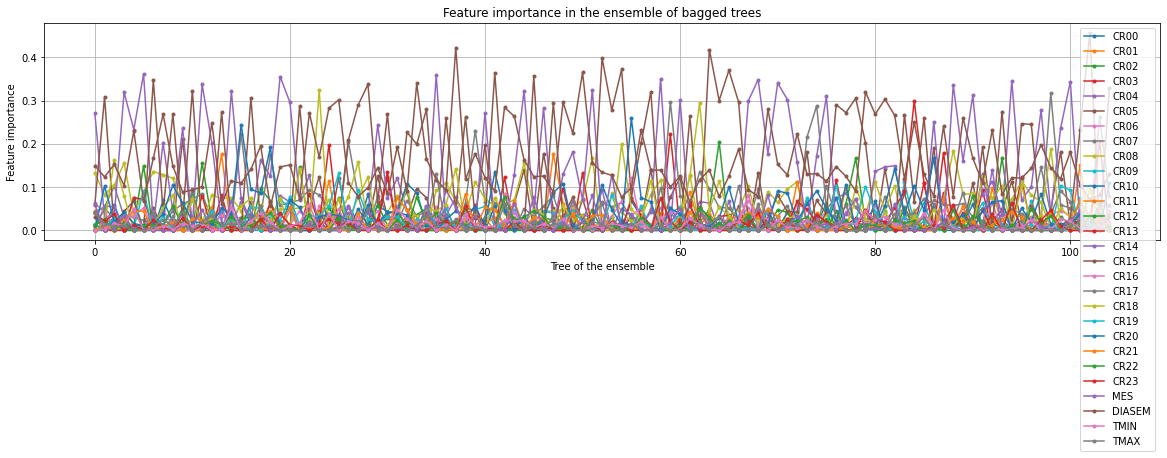

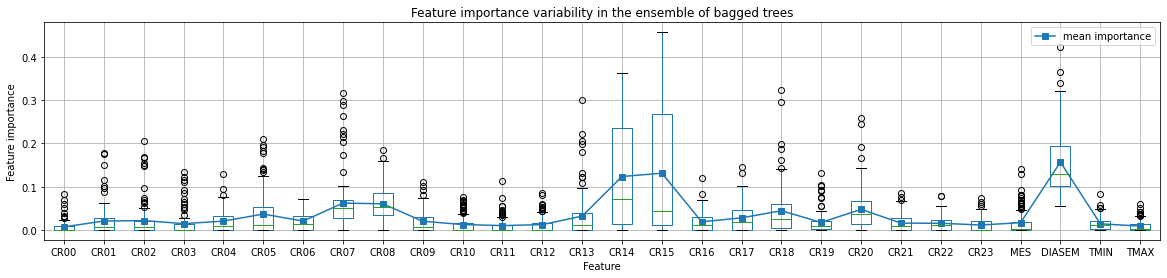

In [17]:
# feature importances of each tree in the ensemble
# Contiene la importancia de cada característica en cada uno de los árboles.
feature_importances_trees = [t['DT'].feature_importances_ for t in bag_class_estim.estimators_]

fig = plt.figure(1, figsize=(20, 4))
plt.plot(feature_importances_trees, '.-', label = INPUTS_BT)
plt.ylabel('Feature importance') 
plt.xlabel('Tree of the ensemble')                                 
plt.title('Feature importance in the ensemble of bagged trees')
plt.grid()
plt.legend()
plt.show()

# global view of feature importances
dfimp =  pd.DataFrame(list(feature_importances_trees), columns=INPUTS_BT)
dfimp.boxplot(figsize=(20, 4))
plt.plot(np.arange(len(INPUTS_BT))+1, dfimp.mean(),'s-', label ='mean importance')
plt.ylabel('Feature importance') 
plt.xlabel('Feature') 
plt.title('Feature importance variability in the ensemble of bagged trees')
plt.legend()
plt.show()

#### 1.4. Ajusta un random forest para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [25]:
# Leemos los datos y los preparamos para el modelo
df_aju = read_data()
INPUTS, OUTPUT, X_train, X_test, y_train, y_test = split_dataset()

In [26]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# find optim nº of trees in the ensemble and max_features
param = {'RF__max_features': range(5, 26, 1), # Number number of features to consider when looking for the best split
         'RF__n_estimators': range(20, 100, 5), # Number of trees in the forest
         } 

pipe =  Pipeline(steps=[('RF', 
                            RandomForestClassifier(
                                        criterion='gini',  # impurity measure
                                        class_weight='balanced', # Weights associated with classes
                                        min_samples_split=6, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0)
                        )])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='f1', # F1 https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_RF = INPUTS  
rf_fit.fit(X_train[INPUTS_RF], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('RF',
                                        RandomForestClassifier(class_weight='balanced',
                                                               min_samples_split=6,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'RF__max_features': range(5, 26),
                         'RF__n_estimators': range(20, 100, 5)},
             scoring='f1')

El siguiente código gradica 2 gráficos:
1. Puntuación promedio de validación cruzada en función del número de árboles (n_estimators).
2. Puntuación promedio de validación cruzada en función de la cantidad de características que se consideran en cada división del árbol (max_features).

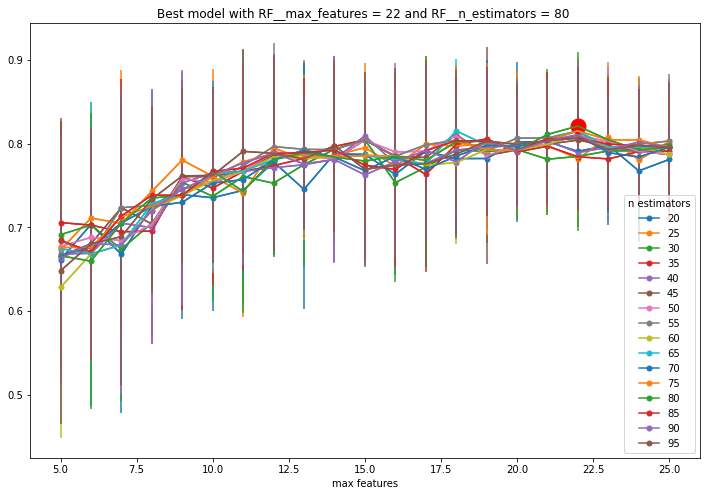

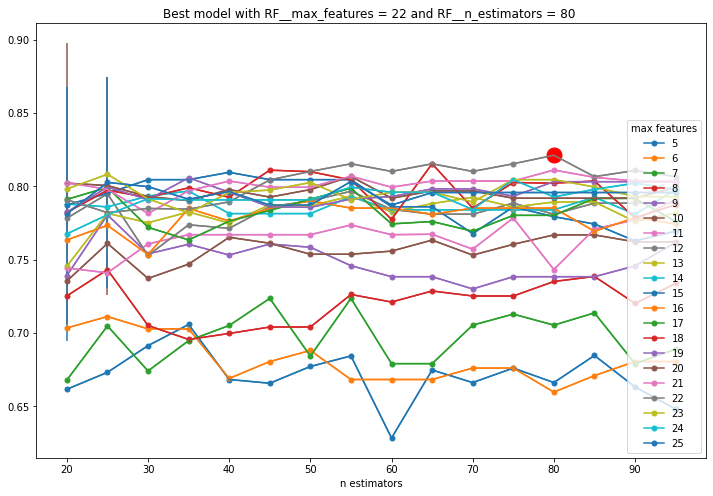

In [27]:
MT.plotModelGridError(rf_fit)

In [28]:
RF_class_estim = rf_fit.best_estimator_['RF']

**Sabiendo el número óptimo de árboles y el número óptimo de características entrenamos el modelo insertando los valores manualmente**

In [20]:
number_estimators = 25

# The number of features to consider when looking for the best split:
m = 5

RF_class_estim = RandomForestClassifier(n_estimators=number_estimators,
                                        max_features=m,
                                        criterion='gini',  # impurity measure
                                        min_samples_split=2, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0)
                     
# fit the bagged trees
INPUTS_BT = INPUTS   
INPUTS_DT = INPUTS
RF_class_estim.fit(X_train[INPUTS_BT], y_train)

RandomForestClassifier(max_features=5, n_estimators=25, random_state=0)

**Imprimimos la importancia de las variables de entrada del Random Forest**

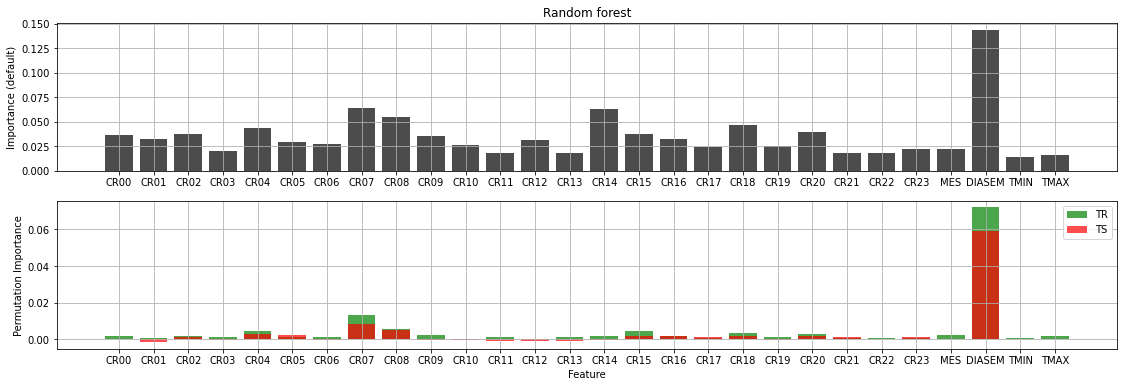

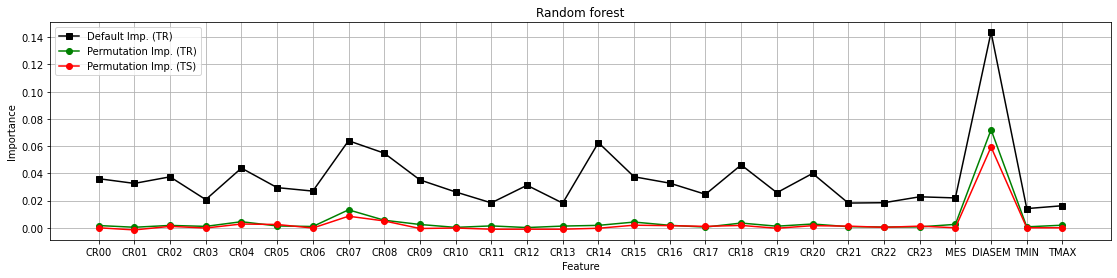

In [21]:
## Feature importance evaluation using "Permutation Importance" (training and test)
importances_tr_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_train[INPUTS_DT], y_train,
                                    n_repeats=10,
                                    random_state=0)

importances_ts_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_test[INPUTS_DT], y_test,
                                    n_repeats=10,
                                    random_state=0)
 
## Plot importances

# Plot the variable importance of each feature given by feature_importances_ attribute
plt.figure(figsize=(19, 6))

plt.subplot(2,1,1)
plt.bar(INPUTS_DT, RF_class_estim.feature_importances_, color='black', alpha=0.7)
plt.ylabel('Importance (default)')
plt.title('Random forest')
plt.grid()

plt.subplot(2,1,2)
plt.bar(INPUTS_DT, importances_tr_RF_class_estim.importances_mean, color='green', alpha=0.7, label='TR')
plt.bar(INPUTS_DT, importances_ts_RF_class_estim.importances_mean, color='red', alpha=0.7, label='TS')
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.legend()
plt.grid()
plt.show()

# Plot the variable importances of each feature (all together)
plt.figure(figsize=(19, 4))

plt.plot(INPUTS_DT, RF_class_estim.feature_importances_, 's-',  color='black', label='Default Imp. (TR)')
plt.plot(INPUTS_DT, importances_tr_RF_class_estim.importances_mean, 'o-', color='green', label='Permutation Imp. (TR)')
plt.plot(INPUTS_DT, importances_ts_RF_class_estim.importances_mean, 'o-', color='red', label='Permutation Imp. (TS)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random forest')
plt.legend()
plt.grid()
plt.show()

**Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación**

In [22]:
# model predictions in training (TR) and test (TS) sets
clf = RF_class_estim
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1, 0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1, 0])

                         TR        TS
Accuracy           0.999566  0.979167
Balanced accuracy  0.994565  0.759965

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 91    1
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 0.99
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 0.99
Precision: 1.0
Recall: 0.99
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 0.99
F1 Score: 0.99
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 12  11
         0  1 552

Accuracy: 0.98
No Information Rate: 0.94
P-Value [Acc > NIR]: 0.01
Kappa: 0.66
Mcnemar's Test P-Value: 0.01
Sensitivity: 1.0
Specificity: 0.52
Precision: 0.92
Recall: 0.52
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.98
Balanced accuracy: 0.76
F1 Score: 0.67
Positive label: 1


In [29]:
# Ahora probamos con SMOTE

smote = SMOTE(random_state = 11)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# Define pipeline with SMOTE to balance classes
pipe_balanced = imbalanced_make_pipeline(RandomForestClassifier(
                                            criterion='gini',  # impurity measure
                                            min_samples_split=6, # Minimum number of obs in node to keep cutting
                                            min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                            max_features=22, # GS_CV - Number of features to consider when looking for the best split
                                            n_estimators=80, # GS_CV -  Number of trees in the forest
                                            random_state=0))

# Fit the balanced pipeline
pipe_balanced.fit(X_train_SMOTE[INPUTS_RF], y_train_SMOTE)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_features=22, min_samples_split=6,
                                        n_estimators=80, random_state=0))])

In [30]:
# model predictions in training (TR) and test (TS) sets
clf = pipe_balanced
y_train_pred = clf.predict(X_train_SMOTE[INPUTS_RF]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_RF]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train_SMOTE,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train_SMOTE,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train_SMOTE, y_train_pred, labels=[1,0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1,0])

                         TR        TS
Accuracy           0.999774  0.979167
Balanced accuracy  0.999774  0.843305

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    1    0
         1 2210    1
         0    0 2211

Accuracy: 1.0
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.5
Detection Rate: 0.5
Detection prevalence: 0.5
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 16   7
         0  5 548

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.01
Kappa: 0.72
Mcnemar's Test P-Value: 0.77
Sensitivity: 0.99
Specificity: 0.7
Precision: 0.76
Recall: 0.7
Prevalence: 0.96
Detection Rate: 0.95
Detection prevalence: 0.96
Balanced accuracy: 0.84
F1 Score: 0.73
Positive label: 1


#### 1.5. Ajusta un gradient boosting para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [31]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_aju = read_data()
INPUTS, OUTPUT, X_train, X_test, y_train, y_test = split_dataset()

In [32]:
number_estimators = 100
learning_rate = 0.08
max_depth = 3
min_impurity_decrease =  0.001 * np.var(y_train)

smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('GB', GradientBoostingClassifier(n_estimators=number_estimators,
                                            learning_rate = learning_rate,
                                            max_depth = max_depth,
                                            max_features = 1.0, # 'auto', ‘sqrt’, ‘log2’, int or float, default=None
                                            loss = 'log_loss',   # binomial and multinomial deviance
                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                            min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                            random_state=0))]) # For replication

INPUTS_BT = INPUTS
nFolds = 10
pipe.fit(X_train[INPUTS_BT], y_train) # Search in grid

Pipeline(steps=[('scaler', StandardScaler()),
                ('GB',
                 GradientBoostingClassifier(learning_rate=0.08,
                                            max_features=1.0,
                                            random_state=0))])

In [33]:
# model predictions in training (TR) and test (TS) sets
clf = pipe
y_train_pred = clf.predict(X_train[INPUTS_BT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_BT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1,0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1,0])

                         TR        TS
Accuracy           0.995929  0.982639
Balanced accuracy  0.995929  0.845114

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    1    0
         1 2198   13
         0    5 2206

Accuracy: 1.0
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.99
Mcnemar's Test P-Value: 0.1
Sensitivity: 1.0
Specificity: 0.99
Precision: 1.0
Recall: 0.99
Prevalence: 0.5
Detection Rate: 0.5
Detection prevalence: 0.5
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 16   7
         0  3 550

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.75
Mcnemar's Test P-Value: 0.34
Sensitivity: 0.99
Specificity: 0.7
Precision: 0.84
Recall: 0.7
Prevalence: 0.96
Detection Rate: 0.95
Detection prevalence: 0.97
Balanced accuracy: 0.85
F1 Score: 0.76
Positive label: 1


#### 1.6. Utiliza staking con tus mejores tres modelos para intentar mejorar la soluciones obtenidas.
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación

Vamos a usar BT, RF y GB como modelos base para el stacking

In [5]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_aju = read_data()
INPUTS, OUTPUT, X_train, X_test, y_train, y_test = split_dataset()

Cargamos los modelos dentro de la carpeta **models**

In [6]:
loaded_btree = pickle.load(open("./models/bagged_tree_v2.pickle", "rb"))
loaded_rf = pickle.load(open("./models/random_forest_v2.pickle", "rb"))
loaded_gb = pickle.load(open("./models/gradient_boostingv2.pickle", "rb"))

De manera adicional, también cargamos los modelos en los que hemos usado **SMOTE** para balancear las clases y observar si a stacking le afecta o no.

In [7]:
loaded_btree_smote = pickle.load(open("./models/bagged_tree_v2.pickle", "rb"))
loaded_rf_smote = pickle.load(open("./models/random_forest_SMOTE.pickle", "rb"))
loaded_ST_smote = pickle.load(open("./models/simple_tree_SMOTE.pickle", "rb"))

Primero realizamos el stacking con los modelos base que hemos entrenado anteriormente sin SMOTE. Hemos asignado el peso en función del F1 score que hemos obtenido en el conjunto de test en los distintos modelos.

In [8]:
weights = [0.4, 0.1, 0.5]
stacked_reg = VotingClassifier(estimators = [('GB', loaded_gb), ('BT', loaded_btree), ('RF', loaded_rf)], weights = weights)
stacked_reg = stacked_reg.fit(X_train, y_train)
stacked_reg.get_params()

{'estimators': [('GB',
   GradientBoostingClassifier(learning_rate=1.0, max_depth=1, max_features=1.0,
                              n_estimators=5000, random_state=0)),
  ('BT',
   BaggingClassifier(base_estimator=Pipeline(steps=[('DT',
                                                     DecisionTreeClassifier(random_state=999))]),
                     n_estimators=105, random_state=150)),
  ('RF',
   RandomForestClassifier(class_weight='balanced', max_features=22,
                          min_samples_split=6, n_estimators=80, random_state=0))],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'hard',
 'weights': [0.4, 0.1, 0.5],
 'GB': GradientBoostingClassifier(learning_rate=1.0, max_depth=1, max_features=1.0,
                            n_estimators=5000, random_state=0),
 'BT': BaggingClassifier(base_estimator=Pipeline(steps=[('DT',
                                                   DecisionTreeClassifier(random_state=999))]),
                   n_estim

Guardamos el modelo en la carpeta **models**

In [9]:
# save model
with open('./models/stacked_reg_model01.pickle', 'wb') as file:
    pickle.dump(stacked_reg, file)

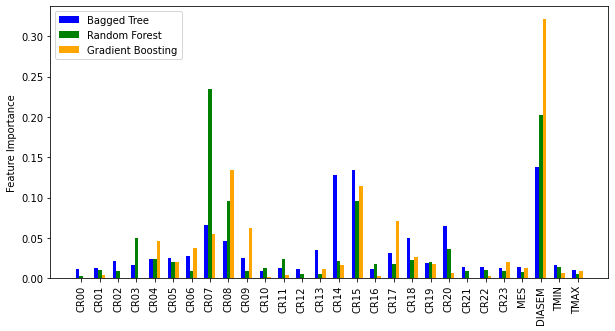

In [10]:
# Get feature importances for each model
btree_importances = [t['DT'].feature_importances_ for t in loaded_btree.estimators_]
rf_importances = loaded_rf.feature_importances_
gb_importances = loaded_gb.feature_importances_

# Calculate mean feature importances for bagged tree
bt_mean_importances = np.mean(btree_importances, axis=0)

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Plot feature importances for each model
ax.bar(np.arange(len(INPUTS))-0.2, bt_mean_importances, width=0.2, label='Bagged Tree', color='blue')
ax.bar(np.arange(len(INPUTS)), rf_importances, width=0.2, label='Random Forest', color='green')
ax.bar(np.arange(len(INPUTS))+0.2, gb_importances, width=0.2, label='Gradient Boosting', color='orange')

# Add x-axis ticks and labels
ax.set_xticks(range(len(INPUTS)))
ax.set_xticklabels(INPUTS, rotation=90)

# Add y-axis label
ax.set_ylabel('Feature Importance')

# Add legend
ax.legend()

# Show plot
plt.show()


In [11]:
# estimations using the stacked models
y_train_stack = stacked_reg.predict(X_train)
y_test_stack = stacked_reg.predict(X_test)

# errors
acc_tr = metrics.accuracy_score(y_train_stack, y_train)
acc_ts = metrics.accuracy_score(y_test_stack, y_test)

acc_bal_tr = metrics.balanced_accuracy_score(y_train_stack, y_train)
acc_bal_ts = metrics.balanced_accuracy_score(y_test_stack, y_test)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print(f'accuracy(TR, stack) = {acc_tr}')
print(f'accuracy(TS, stack) = {acc_ts}')
print(f'accuracy_balanced(TR, stack) = {acc_bal_tr}')
print(f'accuracy_balanced(TS, stack) = {acc_bal_ts}')

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_stack, labels=[1,0])

                    TR        TS
Accuracy           1.0  0.986111
Balanced accuracy  1.0  0.964327
accuracy(TR, stack) = 1.0
accuracy(TS, stack) = 0.9861111111111112
accuracy_balanced(TR, stack) = 1.0
accuracy_balanced(TS, stack) = 0.9643270546143323

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1 92    0
         0  0 2211

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.96
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 1


In [12]:
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_stack, labels=[1,0])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1 16   7
         0  1 552

Accuracy: 0.99
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.79
Mcnemar's Test P-Value: 0.07
Sensitivity: 1.0
Specificity: 0.7
Precision: 0.94
Recall: 0.7
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 0.97
Balanced accuracy: 0.85
F1 Score: 0.8
Positive label: 1


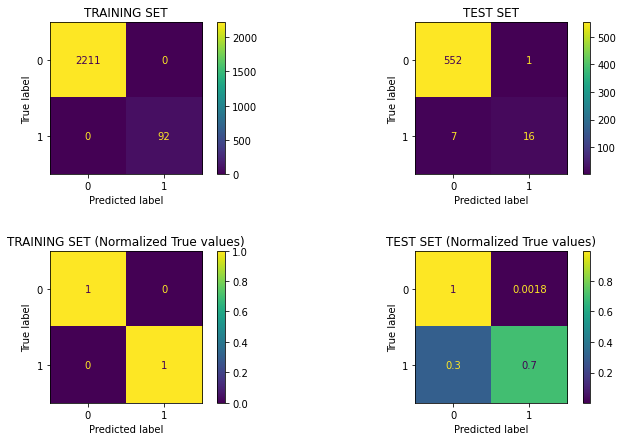

In [13]:
# Plot the confusion matrix for the training and test set
clf = stacked_reg

fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')


ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.subplots_adjust(hspace=0.5)  # Ajuste espacio vertical entre filas

plt.show()

Analisis de las métricas más relevantes obtenidas con **STACKING** para nuestro problema:

| Metrics              | TR        | TS        |
|----------------------|-----------|-----------|
| Accuracy             | 1.0       | 0.986111  |
| Balanced accuracy    | 1.0       | 0.964327  |

Obtenemos un Balanced Accuracy en Train de 1.0 y en test de 0.96, consideramos que es un resultado bastante bueno.

Métricas obtenidas con el conjunto de datos de entrenamiento:

**MÉTRICAS EN TRAINING:**

Confusion Matrix and Statistics

|         | Prediction 1 | Prediction 0 |
|---------|-------------|--------------|
| Reference 1 | 92        | 0          |
| Reference 0 | 0           | 2211         |

Nos da buenos resultados, teniendo 92 muestras de la clase 1 (True Positives - Festivos) clasificadas correctamente y 2211 muestras de la clase 0 (True Negatives - No festivos). Además, el modelo no cometió ningún error de clasificación para la clase 1 (festivos) ni para la clase 0 (falsos positivos). 

| Metrics              | Value    |
|----------------------|-----------|
| Accuracy             | 1.0       |
| No Information Rate  | 0.92       |
| P-Value [Acc > NIR]   | 0.0       |
| Sensitivity          | 1.0       |
| Specificity          | 1.0       |
| **Precision**            | 1.0       |
| Recall               | 1.0       |
| Detection Rate       | 0.5       |
| **Balanced accuracy**    | 1.0      |
| **F1 Score**             | 1.0      |
| Positive label       | 1         |

En general, el modelo parece tener un buen rendimiento en los datos de entrenamiento, con una alta tasa de precisión, sensibilidad y especificidad. Fijándonos en el F1 score, podemos ver que hemos obtenido un resultado de 0.95, lo cual es muy bueno teniendo en cuenta la naturaleza de nuestro conjunto de datos.

A continuación vamos a analizar las métricas obtenidas con el conjunto de datos de test:


**MÉTRICAS EN TEST:**

Confusion Matrix and Statistics

|         | Prediction 1 | Prediction 0 |
|---------|--------------|--------------|
| Reference 1 | 16           | 7            |
| Reference 0 | 1            | 552          |

Podemos observar que el modelo ha clasificado correctamente 16 muestras de la clase 1 (Festivos) y 552 muestras de la clase 0 (días laborables). Además, podemos ver que el modelo ha cometido 7 errores de clasificación en los festivos (clase 1) y 1 error de clasificación para los días laborables (clase 0). 

El rendimiento del modelo parece haber disminuido en los datos de prueba, ya que la sensibilidad y la precisión son más bajas y el número de falsos negativos es más alto. 


| Metrics              | Value    |
|----------------------|-----------|
| Accuracy             | 0.99      |
| No Information Rate  | 0.93      |
| P-Value [Acc > NIR]   | 0.0       |
| Sensitivity          | 1.0       |
| Specificity          | 0.7       |
| **Precision**            | 0.94      |
| Recall               | 0.7       |
| Detection Rate       | 0.96      |
| **Balanced accuracy**    | 0.85      |
| **F1 Score**             | 0.8       |
| Positive label       | 1         |

Por último, observando el balance accuracy y el F1 score del modelo con los datos de test, podemos ver que hemos obtenido un resultado más que aceptable, teniendo en cuenta la calidad de nuestros datos.

## Compare single models with stacked one

#### 1.7. Crea un número de variables reducido que contengan la información recogida en las variables CR00 a CR23 y crea un árbol sencillo basado en estas variables.
- El conjunto de variables creado tienen que ser una combinación lineal de CR00, ..., CR23
- Optimiza la complejidad del árbol
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables, explicando el significado físico de las variables más importantes
- Compara los errores en TR y TS y la lógica del modelo con el creado anteriormente en el apartado 1.2.


In [12]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.8 Compara todos los modelos creados en términos de complejidad, interpretabilidad y errores
- Discute el posible impacto que tiene en los modelos el que existan menos festivos que laborables
- Compara la complejidad en términos de nº de parámetros y estructura del modelo, variables utilizadas, importancia de las mismas
- Compara la capacidad de generalización de los modelos utilizando TS y las diferencias en las matrices de confusión
- Estudia la tasa de fallos de los modelos dependiendo del día de la semana
- Indica qué modelo o modelos son los más prometedores para poner en producción, justificando la selección

In [13]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


---
### 2. VALIDACIÓN FINAL DE LOS MODELOS CON EL DATASET VAL_DATOS_DEM_C3

Se correpondería como si los todos los modelos creados anteriormente se ponen en producción el 1 enero de 2022 y se tienen estimando la festividad durante todo el año para ver qué tal funcionan.

Recuerda, no se debería ver ningún resultado sobre este dataset hasta haber completado todos los apartados anteriores.

Carga datos de validación

In [14]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_val = pd.read_csv('VAL_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_val.FECHA = pd.to_datetime(df_val.FECHA, format='%d/%m/%Y') 
s=df_val.loc[:,'FECHA']
df_val['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_val['ANNO']
del df_val['DIA']

print('Tamaño de df_val con los datos cargados:', df_val.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
print(df_val)

Tamaño de df_val con los datos cargados: (357, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):
          FECHA      CR00      CR01      CR02      CR03      CR04      CR05  \
0    2022-01-01  0.038935  0.037313  0.035291  0.033673  0.032924  0.033235   
1    2022-01-02  0.035271  0.033313  0.031889  0.031411  0.031302  0.031975   
2    2022-01-03  0.033756  0.032003  0.030669  0.030051  0.030199  0.031280   
3    2022-01-04  0.034484  0.032505  0.031375  0.030540  0.030431  0.031324   
4    2022-01-05  0.034669  0.032213  0.030933  0.030382  0.030527  0.031611   
..          ...       ...       ...       ...       ...       ...       ...   
352  2022-12-27  0.033279  0.031139  0.029907  0.029433  0.029757  0.030972   
353  2022-12-28  0.033250  0.031186  0.029934  0.029447  0.029821  0.030942   
354  2022-12-29  0.033718  0.031695  0.030290  0.029717  0.030014  0.031075   
355  2022-12-30  0.033673  0.031494  0.030124  0.029639  0.029629  0.030732   
356  20

#### 2.1. Compara los errores obtenidos en validación con los observados previamente en ajuste/test
- Una vez terminados todos los ajustes de los modelos en el apartado 1.1., ejecuta los mismos para estimar si los días de 2022 son festivos o no (conjunto df_val)
- Muestra los resultados de clasificación obtenidos en el nuevo dataset (accuray y tablas de confusión de cada modelo)
- Discute si los errores obtenidos son coherentes con lo que se esperaba como resultado de los análisis previos para estimar la capacidad de generalización de cada uno de los modelos

In [15]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 2.2. Análisis de los días peor clasificados
- Indica en una tabla la lista de los días que se han clasificado incorrectamente por cada uno de los modelos considerados
- Comenta las posibles diferencias y semejanzas, intentando buscar una justificación de por qué ha ocurrido el error de clasificación
- Muestra gráficamente los perfiles de 24 horas de los 3 días más difíciles de clasificar para los modelos, comparándolos con lo esperado según el día de la semana correspondiente

####  Analisis para stacking v1.0

In [17]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# Create a DataFrame with the true labels and predicted labels for the training and test sets
y_train_df = pd.DataFrame({'True label': y_train, 'Predicted label': y_train_stack})
y_test_df = pd.DataFrame({'True label': y_test, 'Predicted label': y_test_stack})

# Filter out the rows where the predicted label does not match the true label
train_errors = y_train_df[y_train_df['True label'] != y_train_df['Predicted label']]
test_errors = y_test_df[y_test_df['True label'] != y_test_df['Predicted label']]

# Print the error tables
print('Training set errors:')
print(train_errors)



Training set errors:
Empty DataFrame
Columns: [True label, Predicted label]
Index: []


In [38]:
print('\nTest set errors:')
print(test_errors)
print(len(test_errors))


Test set errors:
      True label  Predicted label  FESTIVO  DIASEM       FECHA
1698           1                0      1.0     6.0  2018-09-15
581            1                0      1.0     6.0  2015-08-15
504            1                0      1.0     6.0  2015-05-30
2387           1                0      1.0     6.0  2020-08-15
2872           1                0      1.0     6.0  2021-12-25
2497           1                0      1.0     7.0  2020-12-06
2263           1                0      1.0     5.0  2020-04-10
2282           0                1      0.0     4.0  2020-04-30
8


In [33]:
for index, row in test_errors.iterrows():
    festivo_value = df_aju.loc[index, 'FESTIVO']
    diasem_value = df_aju.loc[index, 'DIASEM']
    dia_value = df_aju.loc[index, 'FECHA']
    test_errors.at[index, 'FESTIVO'] = festivo_value
    test_errors.at[index, 'DIASEM'] = diasem_value
    test_errors.at[index, 'FECHA'] = dia_value
test_errors

,True label,Predicted label,FESTIVO,DIASEM,FECHA
1698,1,0,1.0,6.0,2018-09-15
581,1,0,1.0,6.0,2015-08-15
504,1,0,1.0,6.0,2015-05-30
2387,1,0,1.0,6.0,2020-08-15
2872,1,0,1.0,6.0,2021-12-25
2497,1,0,1.0,7.0,2020-12-06
2263,1,0,1.0,5.0,2020-04-10
2282,0,1,0.0,4.0,2020-04-30


In [37]:
# Count the number of occurrences of each DIASEM value in the test_errors DataFrame
counts_by_diasem = test_errors['DIASEM'].value_counts()

# Print the counts by DIASEM
print('Counts by DIASEM:')
print(counts_by_diasem)

Counts by DIASEM:
6.0    5
7.0    1
5.0    1
4.0    1
Name: DIASEM, dtype: int64
